# This notebook trains the first model of my solution

><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/03.01-Score-Function-Basics.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

### Data paths and imports
[ctc_tpu](https://www.kaggle.com/datasets/shlomoron/ctc-tpu) contains an implementation of CTC for tensorflow.  
[aslfr_light](https://www.kaggle.com/datasets/shlomoron/aslfr-light) contains two needed files from the much larger [competition dataset](https://www.kaggle.com/competitions/asl-fingerspelling/data).  
The [TFRecord dataset](https://www.kaggle.com/datasets/shlomoron/aslfr-tfrecords) contains the training data as TFRecords, and is imported stright to the TPU.

In [1]:
import os
import shutil

input_folder='/content/input'
working_folder='/content'

try:
  os.mkdir(input_folder)
except:
  pass

ctc_tpu_path = 'gs://kds-56377fe3e755931e5dec0abf56fc91724117fbe7bab3e27b74e37f3e'
!gsutil -m cp -r  $ctc_tpu_path $input_folder/ctc-tpu

aslfr_light_folder_name = 'asl-fingerspelling'
try:
  os.mkdir(os.path.join(input_folder, aslfr_light_folder_name))
except:
  pass

aslfr_light_bucket = 'kds-0edb6d00755af6434e157bf0f17ca3102a6722fdba4325c7c11b0e8c'
aslfr_light_path = f'gs://{aslfr_light_bucket}'
!gsutil -m cp -r $aslfr_light_path $input_folder/asl-fingerspelling
shutil.copytree(f'{input_folder}/{aslfr_light_folder_name}/{aslfr_light_bucket}',
                f'{input_folder}/{aslfr_light_folder_name}', dirs_exist_ok=True)

tfrecords_path = 'gs://kds-4104ecb783277dae764d8a7e543344b63bd14d4a90cc61b85b9c2307'

Copying gs://kds-56377fe3e755931e5dec0abf56fc91724117fbe7bab3e27b74e37f3e/CTC_TPU.py...
/ [1/1 files][ 56.1 KiB/ 56.1 KiB] 100% Done                                    
Operation completed over 1 objects/56.1 KiB.                                     
Copying gs://kds-0edb6d00755af6434e157bf0f17ca3102a6722fdba4325c7c11b0e8c/character_to_prediction_index.json...
Copying gs://kds-0edb6d00755af6434e157bf0f17ca3102a6722fdba4325c7c11b0e8c/train.csv...
- [2/2 files][  5.0 MiB/  5.0 MiB] 100% Done                                    
Operation completed over 2 objects/5.0 MiB.                                      


### Define where the outpu is save

It is best to save colab output to a mounted google drive, but giving a public notebook access to your drive can be risky, so the default here is saving to the local disk of the colab session. If you familiarized yourself with the code here and feel at ease with granting such acsess, you can unmark the second part in this cell and define appropriate path do a folder in your own drive (the folder that you create a path to should exist already- in this axample, content/drive/MyDrive/kaggle/ASLFR already exist on my drive)

In [192]:
save_folder = '/content/save'
try:
  os.mkdir(save_folder)
except:
  pass

'''
from google.colab import drive
drive.mount('/content/drive')
save_folder_name = 'base_model'
ASLFR_folder = '/content/drive/MyDrive/kaggle/ASLFR'
save_folder = os.path.join(ASLFR_folder, save_folder_name)
try:
  os.mkdir(save_folder)
except:
  pass
'''

Mounted at /content/drive


In [2]:
import json
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from shutil import copyfile

!pip install tensorflow-addons
import tensorflow_addons as tfa

!pip install cached-property
from cached_property import cached_property

!pip install fastparquet
import fastparquet

!pip install Levenshtein
import Levenshtein as lev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.5 MB/s eta 0:00:00


### Import the ctc loss function

In [3]:
# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = f"{input_folder}/ctc-tpu/CTC_TPU.py", dst = f"{working_folder}//CTC_TPU.py")

# import all our functions
from CTC_TPU import classic_ctc_loss

### TPU boilerplate code

In [4]:
# Configure Strategy. Assume TPU...if not set default for GPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=None)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except:
    strategy = tf.distribute.get_strategy()

print(strategy)

### Landmarks indices

In [5]:
NOSE_old=[
    1,2,98,327
]
LNOSE_old = [98]
RNOSE_old = [327]
LIP_old = [ 0,
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP_old = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP_old = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

FACE_old = LIP_old+NOSE_old
FACE_old.sort()

LPOSE_old = [11, 13, 15, 17, 19, 21, 23]
RPOSE_old = [12, 14, 16, 18, 20, 22, 24]
POSE_old = LPOSE_old + RPOSE_old

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_face_{i}' for i in FACE_old] + [f'x_pose_{i}' for i in POSE_old]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_face_{i}' for i in FACE_old] + [f'y_pose_{i}' for i in POSE_old]

SEL_COLS = X + Y

print('SEL_COLS size:' + str(len(SEL_COLS)))

SEL_COLS_x = [x for x in SEL_COLS if 'x' in x]
NOSE = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in NOSE_old]
LNOSE = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in LNOSE_old]
RNOSE = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in RNOSE_old]
LIP = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in LIP_old]
LLIP = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in LLIP_old]
RLIP = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in RLIP_old]
FACE = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and int(x.split('_')[-1]) in FACE_old]

LPOSE = [i for i, x in enumerate(SEL_COLS_x) if 'pose' in x and int(x.split('_')[-1]) in LPOSE_old]
RPOSE = [i for i, x in enumerate(SEL_COLS_x) if 'pose' in x and int(x.split('_')[-1]) in RPOSE_old]
POSE = [i for i, x in enumerate(SEL_COLS_x) if 'pose' in x and int(x.split('_')[-1]) in POSE_old]

LHAND = [i for i, x in enumerate(SEL_COLS_x) if 'left_hand' in x]
RHAND = [i for i, x in enumerate(SEL_COLS_x) if 'right_hand' in x]

POINT_LANDMARKS = FACE+RHAND+LHAND+RPOSE+LPOSE

norm_point = [i for i, x in enumerate(SEL_COLS_x) if 'face' in x and x.split('_')[-1] == '17'][0]

SEL_COLS size:200


### Config and stuff

In [142]:
DEBUG = True

ROWS_PER_FRAME = int(len(SEL_COLS)/2)
PAD = 0.
NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES
print(NUM_NODES)
print(CHANNELS)
pad_token = 'P'
pad_token_idx = 59


with open (f"{input_folder}/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

char_to_num[pad_token] = pad_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

inpdir = f"{input_folder}/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

tffiles = df.file_id.map(lambda x: f'{tfrecords_path}/tfds/{x}.tfrecord').unique()

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

MAX_LEN = 340
batch_size = 64*4
dim = 384
val_len = int(0.05 * len(tffiles))
cache = True
SHUFFLE = -1

if DEBUG:
  MAX_LEN = 64
  batch_size = 16
  dim=48
  val_len = 1
  cache = False
  SHUFFLE = 50

print("Val len: " + str(val_len))

100
600
Val len: 1


### Augmentations functions

In [154]:
def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, l, dtype=tf.int32)
    mask_start = mask_offset
    mask_end = tf.clip_by_value(mask_offset+mask_size,0,l)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_start, mask_end)[...,None],tf.fill([mask_end - mask_start,ROWS_PER_FRAME,3],mask_value))
    if mask_offset+mask_size>l:
      mask_start = 0
      mask_end = mask_offset+mask_size - l
      x = tf.tensor_scatter_nd_update(x,tf.range(mask_start, mask_end)[...,None],tf.fill([mask_end - mask_start,ROWS_PER_FRAME,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_size_x = tf.random.uniform((), *size)
    mask_size_y = tf.random.uniform((), *size)
    mask_offset_x = tf.random.uniform(())
    mask_offset_y = tf.random.uniform(())
    mask_x = ((mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size_x)) | ((0<=x[...,0]) & (x[...,0] < mask_offset_x + mask_size_x -1))
    mask_y = ((mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size_y)) | ((0<=x[...,1]) & (x[...,1] < mask_offset_y + mask_size_y -1))
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

### Helper functions

In [45]:
def tf_nan_mean(x, axis=0, keepdims=False):
    return tf_nan_sum(x, axis=axis, keepdims=keepdims) / tf_nan_count(x, axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

def tf_nan_sum(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims)

def tf_nan_count(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

### Decode

In [9]:
def decode_tfrec(record_bytes):
    schema = {}
    schema["frames"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["phrase"] = tf.io.VarLenFeature(dtype=tf.float32)
    features = tf.io.parse_single_example(record_bytes, schema)

    frames = tf.sparse.to_dense(features["frames"])
    frames = tf.transpose(tf.reshape(frames,(-1, 2, int(len(SEL_COLS)/2))),[0, 2, 1])
    phrase = tf.cast(tf.sparse.to_dense(features["phrase"]), tf.int32)

    out = {}
    out['coordinates']  = frames
    out['phrase'] = phrase
    return out

### Preprocess

In [168]:
def preprocess_continue(inputs, point_landmarks, max_len):
    if tf.rank(inputs) == 3:
        x = inputs[None,...]
    else:
        x = inputs

    mean = tf_nan_mean(tf.gather(x, [norm_point], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
    x = tf.gather(x, point_landmarks, axis=2)
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    x = (x - mean)/std

    length = tf.shape(x)[1]

    x = x[...,:2]
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

    x = tf.concat([
        tf.reshape(x, (-1,length,len(point_landmarks), 2)),
        tf.reshape(dx, (-1,length,len(point_landmarks), 2)),
        tf.reshape(dx2, (-1,length,len(point_landmarks), 2)),
    ], axis = -1)

    if max_len is not None and tf.shape(x)[1] > max_len:
        x = tf.image.resize(x[0], (max_len, tf.shape(x)[2]))
        x = x[None]

    x = tf.concat([
        tf.reshape(x, (-1,tf.shape(x)[1],6*len(point_landmarks))),
    ], axis = -1)
    return tf.cast(x, tf.float32)

def normalize(x, MEANs, STDs):
  x = (x-MEANs)/STDs
  return x

def remove_nans(x):
  x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
  return x

def preprocess(x, point_landmarks, max_len, MEANs, STDs, augment=False):
    coord = x['coordinates']
    coord = tf.concat([coord, tf.zeros(( tf.shape(coord)[0],  tf.shape(coord)[1], 1))], axis = -1)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))
    coord = preprocess_continue(coord, point_landmarks, max_len)[0]
    coord = normalize(coord, MEANs, STDs)
    coord = remove_nans(coord)
    return coord, x['phrase']

### Filter
The first model (this) use filter_by_length. The second model would use filter_by_lev.

In [144]:
RHAND_IDX = [i for i, x in enumerate(SEL_COLS_x) if 'right' in x]
LHAND_IDX = [i for i, x in enumerate(SEL_COLS_x) if 'left' in x]
def f1(): return True
def f2(): return False
def filter_by_length(x):
    frames = x['coordinates']
    phrase = x['phrase']
    rhand_landmarks = tf.gather(frames, RHAND_IDX, axis=1)
    lhand_landmarks = tf.gather(frames, LHAND_IDX, axis=1)
    r_nonan = tf.math.reduce_sum(tf.cast(~tf.math.is_nan(rhand_landmarks[:, 0, 0]), tf.int64))
    l_nonan = tf.math.reduce_sum(tf.cast(~tf.math.is_nan(lhand_landmarks[:, 0, 0]), tf.int64))
    no_nan = tf.math.maximum(r_nonan, l_nonan)
    return tf.cond(2*tf.shape(phrase)[0]<tf.cast(no_nan, tf.int32), true_fn=f1, false_fn=f2)

def filter_by_lev(x, treshold):
    lev = x['lev']
    return tf.cond(lev>treshold, true_fn=f1, false_fn=f2)

### Define sets
val_files_filtered set check the loss and Levenshtein distance on the filtered validation set (same distribution as the train set).  
val_files_unfiltered check the the loss and Levenshtein distance on the validation set, unfiltered (different distribution than the train set, similar distribution to the lederboard set).  
sub_train_files check the Levenshtein distance on a small part of the train set. The Levenshtein distance is the metric, so it is useful to know how much the train set overfit it compared to the validation set, but it take a long time to calculate so we only do it for a small part of the train set.


In [162]:
val_files_filtered = tffiles[:val_len]
val_files_unfiltered = tffiles[:val_len]

if DEBUG:
  train_files = tffiles[val_len:val_len+1]
  sub_train_files = tffiles[val_len:val_len+1]
else:
  train_files = tffiles[val_len:]
  sub_train_files = tffiles[val_len:val_len+3]

### Calculate mean of the features, for later normalization

In [163]:
def preprocess_for_find_mean_std(x, point_landmarks, max_len):
    coord = x['coordinates']
    coord = tf.concat([coord, tf.zeros(( tf.shape(coord)[0],  tf.shape(coord)[1], 1))], axis = -1)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))
    coord = preprocess_continue(coord, point_landmarks, max_len)[0]
    return coord

def sum_and_count(x):
  return tf.cast(tf_nan_sum(x, axis = 0), tf.float64), tf.cast(tf_nan_count(x, axis = 0), tf.float64)

ds = tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
if DEBUG:
    ds = ds.take(128)
ds = ds.map(lambda x: preprocess_for_find_mean_std(x, point_landmarks = POINT_LANDMARKS, max_len = None), tf.data.AUTOTUNE)
ds = ds.map(sum_and_count)
ds = ds.reduce((np.float64(0), np.float64(0)), lambda x, y: (x[0]+y[0], x[1]+y[1]))

sum, count = [x for x in ds]
MEANs = tf.cast(sum/count, tf.float32)

### Calculate STD of the features, for later normalization

In [164]:
def square_distanse(x, mean):
  return tf.cast(tf_nan_sum((x-mean)**2, axis = 0), tf.float64)

ds = tf.data.TFRecordDataset(train_files, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
if DEBUG:
    ds = ds.take(128)
ds = ds.map(lambda x: preprocess_for_find_mean_std(x, point_landmarks = POINT_LANDMARKS, max_len = None), tf.data.AUTOTUNE)
ds = ds.map(lambda x: square_distanse(x, MEANs))
ds = ds.reduce((np.float64(0)), lambda x, y: x+y)

squared_distance = tf.stack([x for x in ds], axis = 0)
STDs = tf.cast((squared_distance/count)**0.5, tf.float32)

### Get dataset function

In [170]:
def get_tfrec_dataset(tfrecords, MEANs = MEANs, STDs = STDs, point_landmarks = POINT_LANDMARKS, batch_size=64, max_len=64, drop_remainder=False,
                      augment=False, shuffle=False,to_filter = False, cache = False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)

    if to_filter:
        ds = ds.filter(filter_by_length)
        #ds = ds.filter(lambda x: filter_by_lev(x, 0.22))

    if DEBUG:
        ds = ds.take(64)

    if cache:
        ds = ds.cache()
    if shuffle:
        if shuffle == -1:
            samples_num = ds.reduce(0, lambda x,_: x+1).numpy()
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    ds = ds.map(lambda x: preprocess(x, point_landmarks, max_len, MEANs, STDs, augment=augment), tf.data.AUTOTUNE)

    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=(PAD, pad_token_idx), padded_shapes=([max_len,CHANNELS],[64]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)

    if shuffle == -1:
      return ds, samples_num
    return ds

In [213]:
train_dataset, num_train = get_tfrec_dataset(train_files, batch_size=batch_size, max_len=MAX_LEN, drop_remainder=True,
                                        augment=True, shuffle=-1, to_filter = True, cache = cache)
sub_train_dataset = get_tfrec_dataset(sub_train_files, batch_size=batch_size, max_len=MAX_LEN, drop_remainder=True,
                                        shuffle=False, to_filter = True, cache = cache)

val_dataset_filtered = get_tfrec_dataset(val_files_filtered, batch_size=batch_size, max_len=MAX_LEN, drop_remainder=True,
                                        shuffle=False, to_filter = True, cache = cache)
val_dataset_unfiltered = get_tfrec_dataset(val_files_unfiltered, batch_size=batch_size, max_len=MAX_LEN, drop_remainder=True,
                                        shuffle=False, to_filter = False, cache = cache)

print(num_train)
INPUT_SHAPE = [MAX_LEN, CHANNELS]
batch = next(iter(val_dataset_filtered))
batch[0].shape, batch[1].shape

128


(TensorShape([16, 64, 600]), TensorShape([16, 64]))

In [183]:
#Copied from previous comp 1st place model: https://www.kaggle.com/code/hoyso48/1st-place-solution-training
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=6, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

def positional_encoding(maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

In [184]:
steps_per_epoch = num_train//batch_size
print("num_train: " + str(num_train))
print("batch_size: " + str(batch_size))
print("steps_per_epoch: " + str(steps_per_epoch))

dropout_start_epoch = 0

dropout_step = dropout_start_epoch * steps_per_epoch
print("dropout_step: " + str(dropout_step))

num_train: 128
batch_size: 16
steps_per_epoch: 8
dropout_step: 0


In [185]:
def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]

    loss = classic_ctc_loss(
            labels=labels,
            logits=logits,
            label_length=label_length,
            logit_length=logit_length,
            blank_index=pad_token_idx,
        )
    loss = tf.reduce_mean(loss)
    return loss

In [215]:
def get_model(dim = 384, dropout_step=0):
    with strategy.scope():
        inp = tf.keras.Input(INPUT_SHAPE)
        x = inp

        x = tf.keras.layers.Masking(mask_value=0.0)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

        x = Conv1DBlock(dim,11,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,7,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,3,drop_rate=0.2)(x)

        x = x + positional_encoding(INPUT_SHAPE[0], dim)

        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,11,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,7,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,3,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,11,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,7,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,3,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,11,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,7,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,3,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,11,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,7,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,3,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = tf.keras.layers.Dense(dim*2,activation='relu',name='top_conv')(x)
        x = LateDropout(0.4, start_step=dropout_step)(x)
        x = tf.keras.layers.Dense(len(char_to_num))(x)

        model = tf.keras.Model(inp, x)

        loss = CTCLoss

        # Adam Optimizer
        optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4.0)
        optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

        model.compile(loss=loss, optimizer=optimizer)

        return model

tf.keras.backend.clear_session()

print('dim: ' + str(dim))

model = get_model(dim = dim, dropout_step = dropout_step)
model(batch[0])
model.summary()

dim: 48
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 600)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 64, 600)      0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 64, 48)       28800       ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 48)       192         ['stem_conv[0][0]']              
                                                                                      

In [187]:
def num_to_char_fn(y):
    return [num_to_char.get(x, "") for x in y]

@tf.function()
def decode_phrase(pred):
    x = tf.argmax(pred, axis=1)
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    output_text = []
    for result in pred:
        result = "".join(num_to_char_fn(decode_phrase(result).numpy()))
        output_text.append(result)
    return output_text

In [188]:
N_EPOCHS = 500
N_WARMUP_EPOCHS = 5
LR_MAX = 1e-3
WD_RATIO = 0.05
WARMUP_METHOD = "exp"

### Calculate the Levenshtein distance (the metric) during training- it takes a lot of time, so it's not done for each  epoch

In [229]:
with open (f"{input_folder}/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}


val_set_filtered = [x for x in val_dataset_filtered]
val_set_unfiltered = [x for x in val_dataset_unfiltered]
sub_train_set_ = [x for x in sub_train_dataset]

lev_dist_val_filtered = []
lev_dist_val_unfiltered = []
lev_dist_sub_train = []
val_set_unfiltered_loss_list = []

with open (f"{input_folder}/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

class val_lev_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        val_set_unfiltered_loss = self.model.evaluate(val_dataset_unfiltered, verbose = 0)
        val_set_unfiltered_loss_list.append(val_set_unfiltered_loss)
        print('Val unfiltered loss: ' + str(val_set_unfiltered_loss))
        if (epoch+1)%50 == 0:
          lev_dist = calculate_lev(self.model, val_set_filtered)
          print('Val filtered lev distance: '+str(lev_dist))
          lev_dist_val_filtered.append(lev_dist)
          lev_dist = calculate_lev(self.model, lev_dist_val_unfiltered)
          print('Val unfiltered lev distance: '+str(lev_dist))
          lev_dist_val_unfiltered.append(lev_dist)
          lev_dist = calculate_lev(self.model, sub_train_set_)
          print('Sub train lev distance: '+str(lev_dist))
          lev_dist_sub_train.append(lev_dist)

def calculate_lev(model, dataset):
    preds = []
    targets = []
    scores = []
    for batch_idx in range(len(dataset)):
        preds_batch = model.predict(dataset[batch_idx][0], verbose = 0)
        targets_batch = dataset[batch_idx][1]
        for pred_idx in range(len(preds_batch)):
            preds.append("".join([rev_character_map.get(s, "") for s in decode_phrase(preds_batch[pred_idx]).numpy()]))
            targets.append("".join([rev_character_map.get(s, "") for s in targets_batch[pred_idx].numpy()]))

    N = [len(phrase) for phrase in targets]
    lev_dist = [lev.distance(preds[i], targets[i]) for i in range(len(targets))]
    metric_result = (np.sum(N) - np.sum(lev_dist))/np.sum(N)
    return metric_result


### Learning scheduler

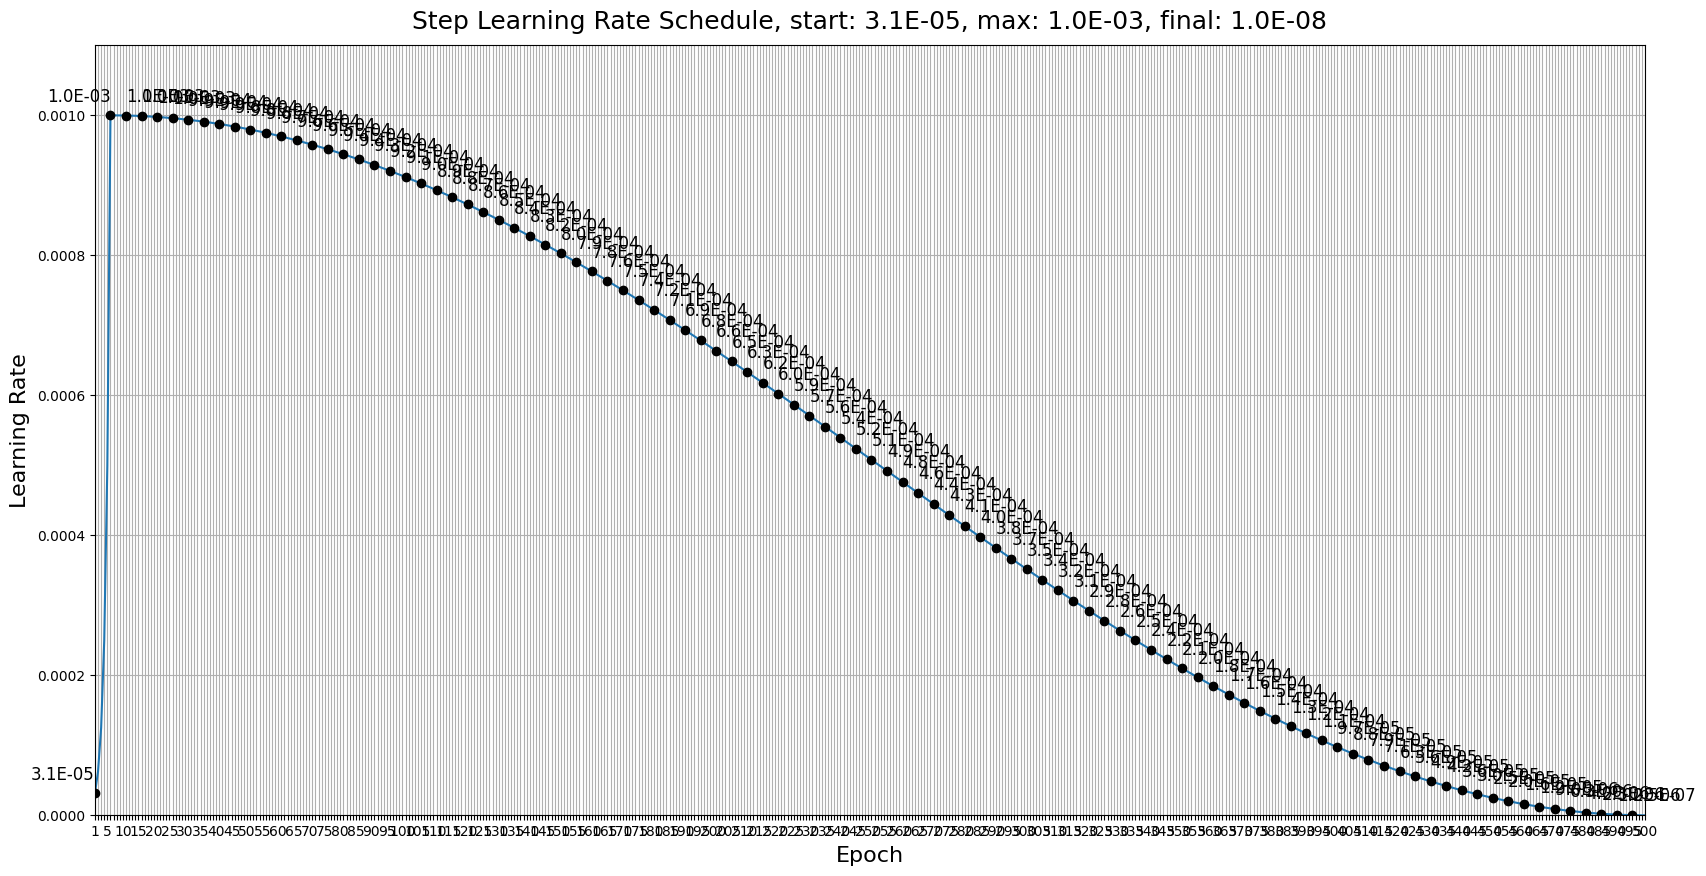

In [193]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

try:
  os.mkdir(f'{save_folder}/weights')
except:
  pass
class save_model_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%50 == 0:
            self.model.save_weights(f"{save_folder}/weights/model_epoch_{epoch}.h5")

In [232]:
N_EPOCHS_to_fit = 500
if DEBUG:
  N_EPOCHS_to_fit = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset_filtered,
    epochs=N_EPOCHS_to_fit,
    verbose = 2,
    callbacks=[
        save_model_callback(),
        lr_callback,
        WeightDecayCallback(),
        val_lev_callback(),
    ]
)

learning rate: 3.13e-05, weight decay: 1.56e-06
Epoch 1/20
Val unfiltered loss: 215.05447387695312
8/8 - 8s - loss: 259.9786 - val_loss: 216.4380 - lr: 3.1250e-05 - 8s/epoch - 1s/step
learning rate: 6.25e-05, weight decay: 3.13e-06
Epoch 2/20
Val unfiltered loss: 214.90676879882812
8/8 - 9s - loss: 259.7966 - val_loss: 216.2863 - lr: 6.2500e-05 - 9s/epoch - 1s/step
learning rate: 1.25e-04, weight decay: 6.25e-06
Epoch 3/20
Val unfiltered loss: 212.72027587890625
8/8 - 10s - loss: 255.1264 - val_loss: 213.9569 - lr: 1.2500e-04 - 10s/epoch - 1s/step
learning rate: 2.50e-04, weight decay: 1.25e-05
Epoch 4/20
Val unfiltered loss: 209.4266357421875
8/8 - 11s - loss: 256.7665 - val_loss: 210.5928 - lr: 2.5000e-04 - 11s/epoch - 1s/step
learning rate: 5.00e-04, weight decay: 2.50e-05
Epoch 5/20
Val unfiltered loss: 188.8752899169922
8/8 - 9s - loss: 241.0337 - val_loss: 189.9093 - lr: 5.0000e-04 - 9s/epoch - 1s/step
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 6/20
Val unfiltered loss

In [233]:
from contextlib import redirect_stdout

with open(f'{save_folder}/modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Exception ignored in: <function _xla_gc_callback at 0x7f34cc6b1ab0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


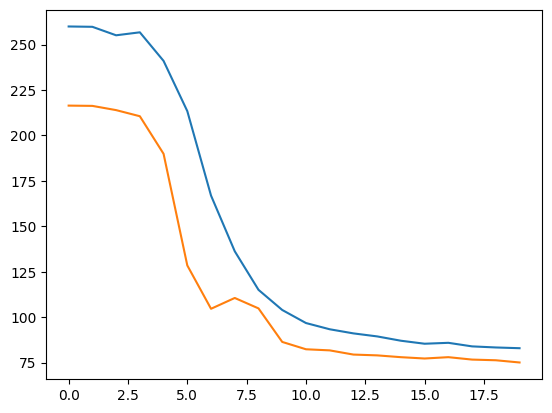

In [234]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [235]:
with open(f'{save_folder}/history.txt', 'w') as f:
    with redirect_stdout(f):
        print(history.history)

In [236]:
with open(f'{save_folder}/lev_dist_val_filtered.txt', 'w') as f:
  for item in lev_dist_val_filtered:
    f.write(str(item)+"\n")
with open(f'{save_folder}/lev_dist_val_unfiltered.txt', 'w') as f:
  for item in lev_dist_val_unfiltered:
    f.write(str(item)+"\n")
with open(f'{save_folder}/lev_dist_sub_train.txt', 'w') as f:
  for item in lev_dist_sub_train:
    f.write(str(item)+"\n")
with open(f'{save_folder}/val_set_unfiltered_loss_list.txt', 'w') as f:
  for item in val_set_unfiltered_loss_list:
    f.write(str(item)+"\n")

In [237]:
pickle.dump(lev_dist_val_filtered, open( f'{save_folder}/lev_dist_val_filtered.p', "wb" ) )
pickle.dump(lev_dist_val_unfiltered, open( f'{save_folder}/lev_dist_val_unfiltered.p', "wb" ) )
pickle.dump(lev_dist_sub_train, open( f'{save_folder}/lev_dist_sub_train.p', "wb" ) )
pickle.dump(history.history, open( f'{save_folder}/history.p', "wb" ) )
pickle.dump(val_set_unfiltered_loss_list, open( f'{save_folder}/val_set_unfiltered_loss_list.p', "wb" ) )

In [ ]:
from google.colab import runtime
runtime.unassign()